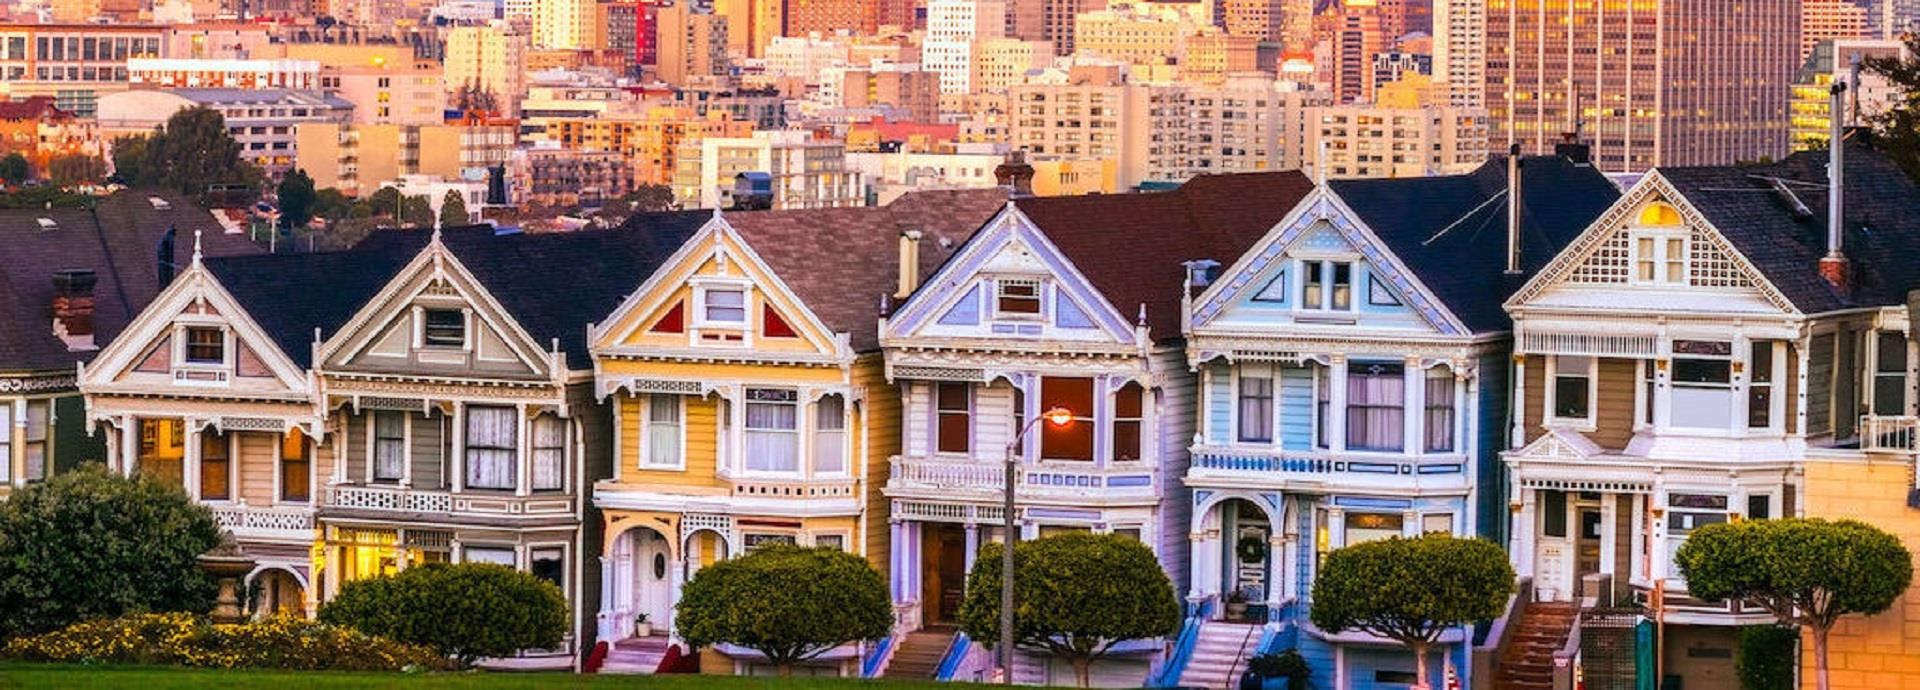

# Zillow Times Series Analysis 
Author: Jennifer Ha
***

## Overview 
This project analyzes New York City Airbnb listings data for the last 12 months (August 2020 - July 2021), which includes detailed information about the hosts and the listings. For the purpose of this project, the Airbnb marketing team would like to know which listings are valuable enough to be selected for their NYC promotion page in the coming winter. With the strong vaccination rate and eased Covid-19 regulation in the city, the team expects that more visitors would be looking for a place to stay in NYC moving forward. Since they cannot go over and compare each listing one by one, the team is looking for a prediction model that they can rely on to carefully select valuable listings that they can promote. They further anticipate to rely on the selected model from this analysis for their future promotions as well.

To help the Airbnb marketing team with accurately selecting the valuable listings in NYC, I'll be comparing classification models and further optimize the best performing model.

## Business Problem
The goal of this analysis is to predict whether a listing is valuable or not. The Airbnb marketing team has decided to consider top 25% listings as valuable, and have asked to calculate a weighted review scores rating to reward listings with more number of reviews and penalize listings with less number of reviews.

The team should be able to use the best model from this analysis to decide which listings are valuable and should be promoted to people who are searching for a place to stay when they visit New York City. We will focus on accuracy, precision, and ROC-AUC scores to determine which model performs the best. In this problem, accurately identifying a valuable listing is important as we cannot falsely advertise a listing with poor ratings.

## Data

This data represents median monthly housing sales prices for 265 zip codes over the period of April 1996 through April 2018 as reported by Zillow.

Each row represents a unique zip code. Each record contains location info and median housing sales prices for each month.

There are 14,723 rows and 272 variables:

RegionID: Unique index, 58196 through 753844
RegionName: Unique Zip Code, 1001 through 99901
City: City in which the zip code is located
State: State in which the zip code is located
Metro: Metropolitan Area in which the zip code is located
CountyName: County in which the zip code is located
SizeRank: Numerical rank of size of zip code, ranked 1 through 14723
1996-04 through 2018-04: refers to the median housing sales values for April 1996 through April 2018, that is 265 data points of monthly data for each zip code


In [1]:
# Import all libraries & packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error


In [2]:
# Import data into a dataframe and preview 
df = pd.read_csv('data/zillow_data.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
# Drop unnecessary column
df.drop(['RegionID','SizeRank'], axis=1, inplace=True)

df.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


First, let's rename the "RegionName" column to "Zipcode".

In [4]:
# Rename "RegionName" to "Zipcode" 
df = df.rename(columns={'RegionName': 'ZipCode'})

In [ ]:
#Calculate historical return on investment
df['ROI'] = (((df['2018-04']-df['2009-07'])/df['2009-07'])*100).round(2)

In [ ]:
df.loc[:,'2009-07':'2018-04']

In [5]:
#Calculate historical return on investment
df['ROI'] = (((df['2018-04']-df['2009-07'])/df['2009-07'])*100).round(2)

#Calculate standard deviation of monthly values
df['std'] = df.loc[:,'2009-07':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df['mean'] = df.loc[:,'2009-07':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variation
df['CV'] = df['std']/df['mean']

In [6]:
df.head()

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI,std,mean,CV
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1013300,1018700,1024400,1030700,1033800,1030600,32.01,100980.267490,8.601792e+05,0.117394
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,315000,316600,318100,319600,321100,321800,61.14,42550.483605,2.414358e+05,0.176239
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,320800,321200,321200,323000,326900,329900,33.45,32621.441984,2.828783e+05,0.115320
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1296600,1299000,1302700,1306400,1308500,1307000,30.83,136762.849918,1.104142e+06,0.123864
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,120300,120300,120300,120500,121000,121500,2.36,2544.584652,1.155774e+05,0.022016


Our client mainly wants to focus on CA. let's drop the rest.

In [7]:
# Keep CA state only
df_ca = df[df['State'] == 'CA']

df_ca.info()
df_ca.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1224 entries, 9 to 14712
Columns: 274 entries, ZipCode to CV
dtypes: float64(223), int64(47), object(4)
memory usage: 2.6+ MB


,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI,std,mean,CV
9,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3793900,3778700,3770800,3763100,3779800,3813500,47.03,565248.108783,3.083127e+06,0.183336
15,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,598500,601300,602800,606100,612400,616200,71.74,84686.805544,4.380038e+05,0.193347
27,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,408600,410900,413700,417900,424300,430100,139.74,88393.057380,2.595811e+05,0.340522
30,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1907500,1922100,1952400,1974500,1975900,1966900,75.16,313368.979603,1.352452e+06,0.231704
64,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,1009900,1021000,1032400,1042000,1053000,1059700,86.96,163799.440733,7.231915e+05,0.226495


In [8]:
df_ca.head()

,ZipCode,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI,std,mean,CV
9,94109,San Francisco,CA,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,...,3793900,3778700,3770800,3763100,3779800,3813500,47.03,565248.108783,3.083127e+06,0.183336
15,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,...,598500,601300,602800,606100,612400,616200,71.74,84686.805544,4.380038e+05,0.193347
27,94565,Pittsburg,CA,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,...,408600,410900,413700,417900,424300,430100,139.74,88393.057380,2.595811e+05,0.340522
30,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,...,1907500,1922100,1952400,1974500,1975900,1966900,75.16,313368.979603,1.352452e+06,0.231704
64,94501,Alameda,CA,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,...,1009900,1021000,1032400,1042000,1053000,1059700,86.96,163799.440733,7.231915e+05,0.226495


In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State', 'Metro', 'CountyName','ROI','std','mean','CV'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [12]:
melted_df = melt_data(df_ca)

In [13]:
#Change Zipcode dtype to 'str'
melted_df['ZipCode'] = melted_df['ZipCode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%m/%y')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

melted_df.head()

,ZipCode,City,State,Metro,CountyName,ROI,std,mean,CV,value
Date,,,,,,,,,,
1996-04-01,94109,San Francisco,CA,San Francisco,San Francisco,47.03,565248.108783,3.083127e+06,0.183336,766000.0
1996-04-01,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,71.74,84686.805544,4.380038e+05,0.193347,152500.0
1996-04-01,94565,Pittsburg,CA,San Francisco,Contra Costa,139.74,88393.057380,2.595811e+05,0.340522,139200.0
1996-04-01,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,75.16,313368.979603,1.352452e+06,0.231704,340600.0
1996-04-01,94501,Alameda,CA,San Francisco,Alameda,86.96,163799.440733,7.231915e+05,0.226495,222400.0


In [14]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 318744 entries, 1996-04-01 to 2018-04-01
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ZipCode     318744 non-null  object 
 1   City        318744 non-null  object 
 2   State       318744 non-null  object 
 3   Metro       308142 non-null  object 
 4   CountyName  318744 non-null  object 
 5   ROI         317536 non-null  float64
 6   std         318744 non-null  float64
 7   mean        318744 non-null  float64
 8   CV          318744 non-null  float64
 9   value       318744 non-null  float64
dtypes: float64(5), object(5)
memory usage: 26.8+ MB


[Great Recession](https://en.wikipedia.org/wiki/Great_Recession)

Great Recession ended in June 2009

In [15]:
melted_df = melted_df['2009-07-01':'2018-04-01']

melted_df.info()
melted_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128832 entries, 2009-07-01 to 2018-04-01
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ZipCode     128832 non-null  object 
 1   City        128832 non-null  object 
 2   State       128832 non-null  object 
 3   Metro       124380 non-null  object 
 4   CountyName  128832 non-null  object 
 5   ROI         127624 non-null  float64
 6   std         128832 non-null  float64
 7   mean        128832 non-null  float64
 8   CV          128832 non-null  float64
 9   value       128832 non-null  float64
dtypes: float64(5), object(5)
memory usage: 10.8+ MB


,ZipCode,City,State,Metro,CountyName,ROI,std,mean,CV,value
Date,,,,,,,,,,
2009-07-01,94109,San Francisco,CA,San Francisco,San Francisco,47.03,565248.108783,3.083127e+06,0.183336,2593700.0
2009-07-01,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,71.74,84686.805544,4.380038e+05,0.193347,358800.0
2009-07-01,94565,Pittsburg,CA,San Francisco,Contra Costa,139.74,88393.057380,2.595811e+05,0.340522,179400.0
2009-07-01,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,75.16,313368.979603,1.352452e+06,0.231704,1122900.0
2009-07-01,94501,Alameda,CA,San Francisco,Alameda,86.96,163799.440733,7.231915e+05,0.226495,566800.0


## Exploratory Data Analysis (EDA)

average home value by month and year

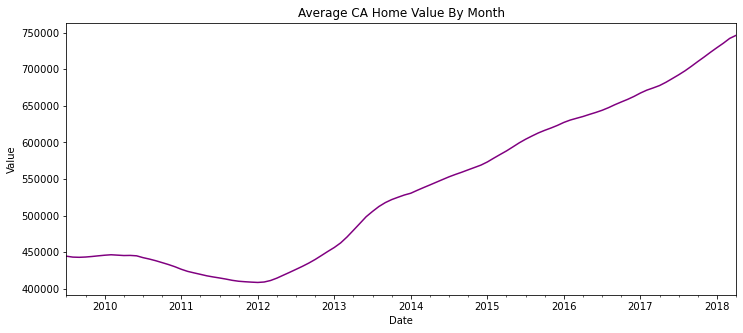

In [25]:
# Resample data by month
monthly_data = melted_df['value'].resample('MS').mean()
monthly_data = monthly_data.fillna(monthly_data.bfill())
monthly_data.plot(figsize=(12,5), color='purple')
plt.title('Average CA Home Value By Month')
plt.ylabel('Value')
plt.show()

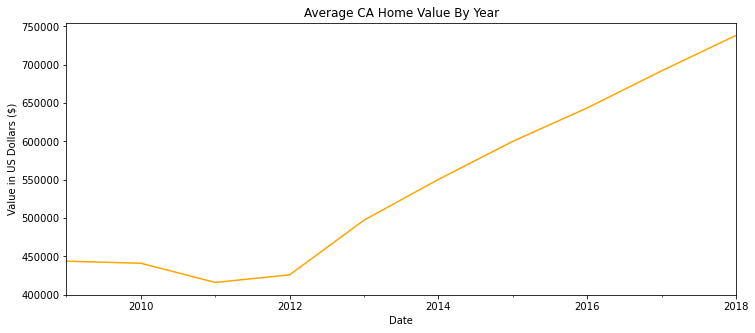

In [26]:
# Resample data by month
yr_data = melted_df['value'].resample('A').mean()
yr_data.plot.line(figsize=(12,5), color='orange')
plt.title('Average CA Home Value By Year')
plt.ylabel('Value in US Dollars ($)')
plt.show()

### Top 10 Metro & County (mean value & mean ROI)

In [27]:
metro_v = melted_df.groupby('Metro')
metro_v = metro_v.value.mean()
metro_v = metro_v.sort_values(ascending=False).head(10)

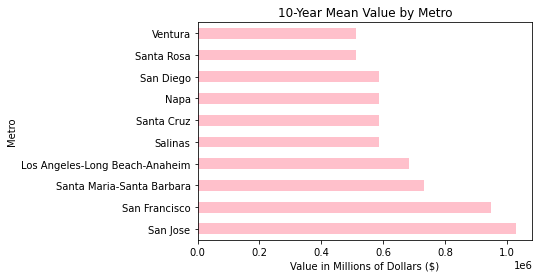

In [28]:
metro_v.plot.barh(color='pink')
plt.title('10-Year Mean Value by Metro')
plt.xlabel('Value in Millions of Dollars ($)')
plt.show()

In [29]:
metro_r = melted_df.groupby('Metro')
metro_r = metro_r.ROI.mean()
metro_r = metro_r.sort_values(ascending=False).head(10)

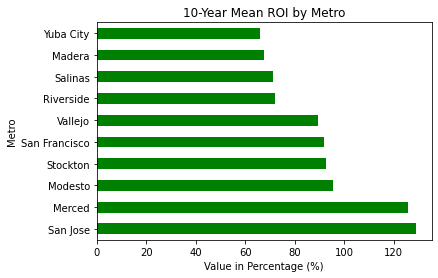

In [30]:
metro_r.plot.barh(color='green')
plt.title('10-Year Mean ROI by Metro')
plt.xlabel('Value in Percentage (%)')
plt.show()

In [31]:
county_v = melted_df.groupby('CountyName')
county_v = county_v.value.mean()
county_v = county_v.sort_values(ascending=False).head(10)

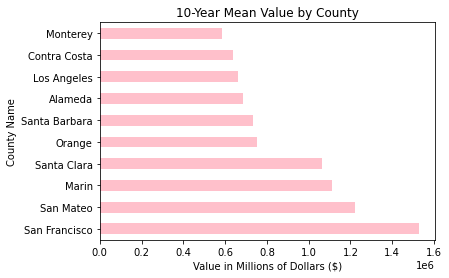

In [32]:
county_v.plot.barh(color='pink')
plt.title('10-Year Mean Value by County')
plt.xlabel('Value in Millions of Dollars ($)')
plt.ylabel('County Name')
plt.show()

In [33]:
county_r = melted_df.groupby('CountyName')
county_r = county_r.ROI.mean()
county_r = county_r.sort_values(ascending=False).head(10)

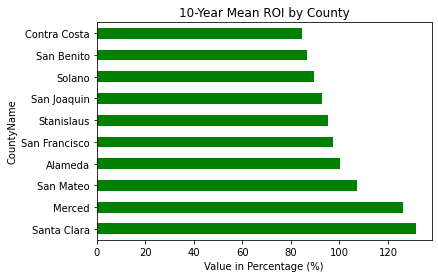

In [34]:
county_r.plot.barh(color='green')
plt.title('10-Year Mean ROI by County')
plt.xlabel('Value in Percentage (%)')
plt.show()

### Top 10 Zipcode (mean value & mean ROI)
In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments. Ideally, if the coefficient of variation formula should result in a lower ratio of the standard deviation to mean return, then the better the risk-return trade-off. Therefore, in these next steps we are going to filter the data some more by calculating the CV value and only selecting values with in the company's risk factor (assume 50 percentile).

In finance, the coefficient of variation allows investors to determine how much volatility, or risk, is assumed in comparison to the amount of return expected from investments.
The lower the ratio of the standard deviation to mean return, the better risk-return trade-off.

In [36]:
#Define upper limit of CV according to risk profile.
upper_cv = melted_df.CV.quantile(.5)
print(f'\nCV upper limit: {upper_cv}')

#Get the 10 counties with highest ROIs within the firms risk profile.
df_top10 = melted_df[melted_df['CV']<upper_cv].sort_values('ROI', axis=0, ascending=False)

#find out the top 10 couties with highest ROI
grp_county = df_top10.groupby('CountyName').sum()['ROI']
grp_county.sort_values(ascending=False)[:10]


CV upper limit: 0.19086587721893816


CountyName
Los Angeles        742607.38
San Diego          406002.26
Orange             384157.78
Fresno             104417.42
Ventura            100095.80
San Bernardino      91558.56
Riverside           80888.60
San Luis Obispo     66635.84
Tulare              58291.52
Placer              52323.72
Name: ROI, dtype: float64

In [37]:

top10_county = list(grp_county.sort_values(ascending=False)[:10].index)
top10_county

['Los Angeles',
 'San Diego',
 'Orange',
 'Fresno',
 'Ventura',
 'San Bernardino',
 'Riverside',
 'San Luis Obispo',
 'Tulare',
 'Placer']

In [38]:
df_top10.shape

(64386, 10)

In [39]:
df_top10 = df_top10.loc[df_top10['CountyName'].isin(top10_county)]
df_top10.shape

(43904, 10)

In [40]:
df_top10['CountyName'].value_counts()

Los Angeles        13990
Orange              7844
San Diego           7314
Fresno              3414
Ventura             2226
San Bernardino      2120
Riverside           1802
San Luis Obispo     1802
Tulare              1802
Placer              1590
Name: CountyName, dtype: int64

In [41]:
df_top10.groupby('CountyName').max()['ROI']

CountyName
Fresno             60.53
Los Angeles        71.71
Orange             72.42
Placer             59.40
Riverside          73.49
San Bernardino     66.11
San Diego          76.20
San Luis Obispo    50.56
Tulare             53.93
Ventura            69.25
Name: ROI, dtype: float64

In [42]:
df_top10.isna().sum()

ZipCode         0
City            0
State           0
Metro           0
CountyName      0
ROI           338
std             0
mean            0
CV              0
value           0
dtype: int64

In [43]:

#Get city and state names for each zip code
ziplist = []
top_ROI = {}

for i in top10_county:
    City = df_top10[df_top10['CountyName']==i].City.values[0]
    Metro = df_top10[df_top10['CountyName']==i].Metro.values[0]
    Zipcode = df_top10[df_top10['CountyName']==i].ZipCode.values[0]
    roi = (df_top10[df_top10['CountyName']==i].max()['ROI'])*100
    
    ziplist.append(Zipcode)
    top_ROI[i] = roi
    print(f'County: {i} \nCity: {City}, Zipcode: {Zipcode}, Metro: {Metro}\n')

County: Los Angeles 
City: Los Angeles, Zipcode: 91303, Metro: Los Angeles-Long Beach-Anaheim

County: San Diego 
City: San Diego, Zipcode: 92104, Metro: San Diego

County: Orange 
City: Santa Ana, Zipcode: 92704, Metro: Los Angeles-Long Beach-Anaheim

County: Fresno 
City: Fresno, Zipcode: 93705, Metro: Fresno

County: Ventura 
City: Ventura, Zipcode: 93001, Metro: Ventura

County: San Bernardino 
City: Chino, Zipcode: 91710, Metro: Riverside

County: Riverside 
City: Corona, Zipcode: 92882, Metro: Riverside

County: San Luis Obispo 
City: Paso Robles, Zipcode: 93446, Metro: San Luis Obispo

County: Tulare 
City: Cutler, Zipcode: 93615, Metro: Visalia

County: Placer 
City: Lincoln, Zipcode: 95648, Metro: Sacramento



In [44]:
zip_v = melted_df.groupby('ZipCode')
zip_v = zip_v.value.mean()
zip_v = zip_v.sort_values(ascending=False).head(10)

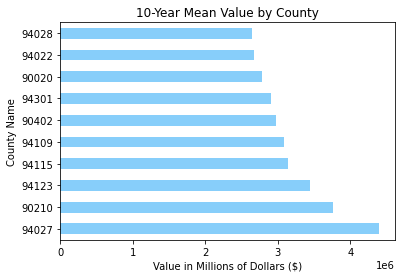

In [45]:
zip_v.plot.barh(color='lightskyblue')
plt.title('10-Year Mean Value by County')
plt.xlabel('Value in Millions of Dollars ($)')
plt.ylabel('County Name')
plt.show()

In [46]:
zip_r = melted_df.groupby('ZipCode')
zip_r = zip_r.ROI.mean()
zip_r = zip_r.sort_values(ascending=False).head(10)

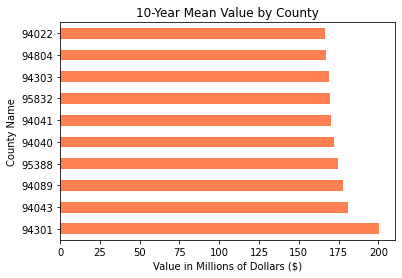

In [47]:
zip_r.plot.barh(color='coral')
plt.title('10-Year Mean Value by County')
plt.xlabel('Value in Millions of Dollars ($)')
plt.ylabel('County Name')
plt.show()

In [48]:
ziplist

['91303',
 '92104',
 '92704',
 '93705',
 '93001',
 '91710',
 '92882',
 '93446',
 '93615',
 '95648']

The monthly and yearly home values seem to be similar. There doesn't seem to be any seasonality now but we will look into data decomposition and explore it further,

In [49]:
x = dict(sorted(top_ROI.items(), key=lambda item: item[1])).keys()

In [50]:
y = dict(sorted(top_ROI.items(), key=lambda item: item[1])).values()

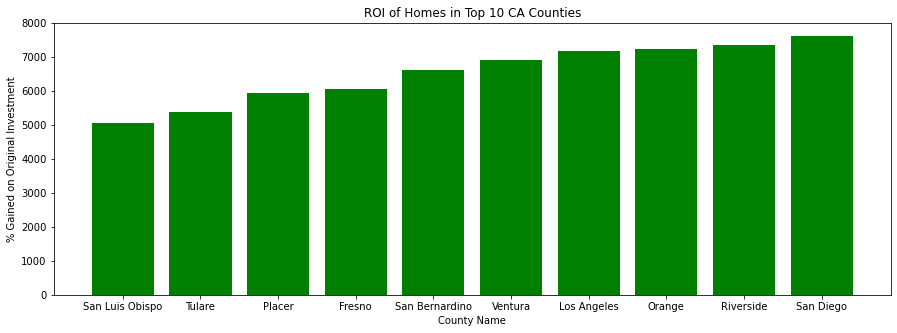

In [51]:
plt.figure(figsize=(15,5))
plt.bar(x, y, color='green', )
plt.title('ROI of Homes in Top 10 CA Counties')
plt.xlabel('County Name')
plt.ylabel('% Gained on Original Investment')
plt.show()